In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import FactorAnalysis
import numpy as np
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

import scipy.stats as stats
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import optuna

In [2]:
df = pd.read_csv('datasets\cleaned_data_QS.csv', encoding='latin1')
score_columns = [col for col in df.columns if 'SCORE' in col]
print(score_columns,'score_columns')
print(df.columns,'all_columns')

['AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE', 'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE'] score_columns
Index(['Rank', 'Institution Name', 'Country', 'Year', 'CS', 'CF', 'RI', 'Age',
       'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE',
       'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE', 'Overall'],
      dtype='object') all_columns


In [3]:
# select lower missing-value ratio as features(used in random forest)
features = ['CS', 'CF', 'RI', 'Age', 'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE','IF_SCORE','IS_SCORE','Overall']
targets = ['IRN_SCORE', 'EO_SCORE', 'S_SCORE']

# Fill missing values with institution-specific mean
def fill_na_with_institution_mean(df, column):
    return df[column].fillna(df.groupby('Institution Name')[column].transform('mean'))

# If still missing, filling with country-specific mean
def fill_na_with_country_mean(df, column):
    return df[column].fillna(df.groupby('Country')[column].transform('mean'))

# Fill initial columns with country mean
cols_to_exclude = ['Institution Name', 'Country']
for col in features:
    if col not in cols_to_exclude:
        df[col] = fill_na_with_institution_mean(df, col)
        df[col] = fill_na_with_country_mean(df, col)

In [4]:
# Check missing
missing = df[df.columns].isnull().sum().values / df.shape[0]   # Calculate missing values ratio
for i,column in zip(missing, df.columns):
    print(f"{i * 100:.2f}% missing in",column)

0.00% missing in Rank
0.00% missing in Institution Name
0.00% missing in Country
0.00% missing in Year
0.00% missing in CS
0.00% missing in CF
0.00% missing in RI
0.24% missing in Age
0.13% missing in STA
0.02% missing in AR_SCORE
0.02% missing in ER_SCORE
0.02% missing in FS_SCORE
0.02% missing in CPF_SCORE
0.11% missing in IF_SCORE
0.13% missing in IS_SCORE
44.60% missing in IRN_SCORE
44.56% missing in EO_SCORE
58.96% missing in S_SCORE
4.13% missing in Overall


In [5]:
# Combine features and targets for imputation
all_columns = features + targets
# Split data for training and testing
train_data = df[df['Year'] >= 2024].dropna(subset=all_columns)   # ensure training data are have no missing values
test_data = df[df['Year'] < 2024]

In [6]:
test_data

,Rank,Institution Name,Country,Year,CS,CF,RI,Age,STA,AR_SCORE,ER_SCORE,FS_SCORE,CPF_SCORE,IF_SCORE,IS_SCORE,IRN_SCORE,EO_SCORE,S_SCORE,Overall
0,1.0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),United States,2018,2.0,2.0,4.0,5.0,2.0,100.0,100.0,100.0,99.9,100.000000,96.100000,NaN,NaN,NaN,100.000000
1,2.0,STANFORD UNIVERSITY,United States,2018,3.0,3.0,4.0,5.0,2.0,100.0,100.0,100.0,99.4,99.600000,72.700000,NaN,NaN,NaN,98.700000
2,3.0,HARVARD UNIVERSITY,United States,2018,3.0,3.0,4.0,5.0,2.0,100.0,100.0,98.3,99.9,96.500000,75.200000,NaN,NaN,NaN,98.400000
3,4.0,CALIFORNIA INSTITUTE OF TECHNOLOGY (CALTECH),United States,2018,1.0,2.0,4.0,5.0,2.0,99.5,85.4,100.0,100.0,93.400000,89.200000,NaN,NaN,NaN,97.700000
4,5.0,UNIVERSITY OF CAMBRIDGE,United Kingdom,2018,3.0,3.0,4.0,5.0,3.0,100.0,100.0,100.0,78.3,97.400000,97.700000,NaN,NaN,NaN,95.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6134,1401.0,Universidad Nacional AutÂ¨Â®noma de Honduras (...,Honduras,2023,4.0,3.0,1.0,5.0,3.0,4.6,5.8,3.6,1.0,1.700000,3.300000,8.1,NaN,NaN,NaN
6135,1401.0,Universidad TecnolÂ¨Â®gica de BolÂ¨Âªvar,Colombia,2023,2.0,4.0,3.0,4.0,2.0,3.0,5.8,2.4,2.2,9.300000,1.300000,8.8,30.9,NaN,36.193548
6136,1401.0,UniversitÂ¨Â¦ Mohammed V de Rabat,Morocco,2023,4.0,2.0,4.0,3.0,3.0,2.8,2.6,3.2,3.6,5.200000,2.800000,51.1,NaN,NaN,NaN
6137,1401.0,University of Craiova,Romania,2023,3.0,2.0,3.0,4.0,3.0,3.3,1.8,2.7,2.0,3.708889,7.284068,7.5,8.7,NaN,NaN


In [7]:
def objective(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 80),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.7, 0.3]),
    }
    rf = RandomForestRegressor(**params, random_state=2025, n_jobs=-1)
    score = cross_val_score(rf, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -score.mean()

In [8]:
best_params_dict = {}

for target in targets:
    X_train = train_data[features]
    y_train = train_data[target]

    # Optuna study
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

    best_params = study.best_params
    best_params_dict[target] = best_params
    best_rf = RandomForestRegressor(**best_params, random_state=2025)
    best_rf.fit(X_train, y_train)

    print(f"Best parameters for {target}: {best_params}")

    # Predict missing values
    X_test = test_data[features]
    test_data.loc[:, target] = best_rf.predict(X_test)

[I 2025-07-18 13:53:45,199] A new study created in memory with name: no-name-70fc2393-15e2-45d6-b00f-86987070c004
[I 2025-07-18 13:53:48,199] Trial 0 finished with value: 23.17341829514009 and parameters: {'n_estimators': 433, 'max_depth': 64, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 23.17341829514009.
[I 2025-07-18 13:53:49,105] Trial 1 finished with value: 23.136568615268065 and parameters: {'n_estimators': 109, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 23.136568615268065.
[I 2025-07-18 13:53:50,085] Trial 2 finished with value: 23.22324973307022 and parameters: {'n_estimators': 148, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 23.136568615268065.
[I 2025-07-18 13:53:51,216] Trial 3 finished with value: 23.273220040558353 and parameters: {'n_estimators': 333, 'max_depth': 9, 'min_s

[I 2025-07-18 13:54:03,904] Trial 33 finished with value: 23.20883083215598 and parameters: {'n_estimators': 138, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 0.3}. Best is trial 1 with value: 23.136568615268065.
[I 2025-07-18 13:54:04,166] Trial 34 finished with value: 23.20599485273584 and parameters: {'n_estimators': 160, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 23.136568615268065.
[I 2025-07-18 13:54:04,413] Trial 35 finished with value: 23.20837958488084 and parameters: {'n_estimators': 121, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.3}. Best is trial 1 with value: 23.136568615268065.
[I 2025-07-18 13:54:04,686] Trial 36 finished with value: 23.58337887189469 and parameters: {'n_estimators': 101, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 0.7}. Best is trial 1 with value: 23.136568615268065.
[I 20

[I 2025-07-18 13:54:12,740] Trial 66 finished with value: 23.234638584670336 and parameters: {'n_estimators': 170, 'max_depth': 34, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 23.136568615268065.
[I 2025-07-18 13:54:12,952] Trial 67 finished with value: 23.278399888476056 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 0.3}. Best is trial 1 with value: 23.136568615268065.
[I 2025-07-18 13:54:13,160] Trial 68 finished with value: 23.152712468267435 and parameters: {'n_estimators': 108, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.3}. Best is trial 1 with value: 23.136568615268065.
[I 2025-07-18 13:54:13,371] Trial 69 finished with value: 23.234726793322213 and parameters: {'n_estimators': 111, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 23.136568615268065

[I 2025-07-18 13:54:22,231] Trial 99 finished with value: 23.421379460364957 and parameters: {'n_estimators': 395, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.3}. Best is trial 85 with value: 23.092571936311327.
[I 2025-07-18 13:54:22,845] A new study created in memory with name: no-name-75cfa05b-c124-40de-830c-26e67af8f113


Best parameters for IRN_SCORE: {'n_estimators': 127, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.3}


[I 2025-07-18 13:54:23,116] Trial 0 finished with value: 16.00662924553134 and parameters: {'n_estimators': 206, 'max_depth': 61, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 16.00662924553134.
[I 2025-07-18 13:54:23,361] Trial 1 finished with value: 15.801459688096221 and parameters: {'n_estimators': 159, 'max_depth': 70, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 15.801459688096221.
[I 2025-07-18 13:54:24,133] Trial 2 finished with value: 14.718524321478492 and parameters: {'n_estimators': 483, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 2 with value: 14.718524321478492.
[I 2025-07-18 13:54:25,016] Trial 3 finished with value: 15.953693103801413 and parameters: {'n_estimators': 442, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 0.7}. Best is trial 2 with value: 14.718524321478492.
[I 

[I 2025-07-18 13:54:44,347] Trial 33 finished with value: 15.138123736923204 and parameters: {'n_estimators': 417, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 12 with value: 14.605593131199713.
[I 2025-07-18 13:54:45,122] Trial 34 finished with value: 14.835008414669176 and parameters: {'n_estimators': 447, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 12 with value: 14.605593131199713.
[I 2025-07-18 13:54:45,719] Trial 35 finished with value: 14.991280850052819 and parameters: {'n_estimators': 353, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.3}. Best is trial 12 with value: 14.605593131199713.
[I 2025-07-18 13:54:46,700] Trial 36 finished with value: 15.70660919732178 and parameters: {'n_estimators': 428, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 0.7}. Best is trial 12 with value: 14.605593131199

[I 2025-07-18 13:55:06,735] Trial 66 finished with value: 15.655463020302241 and parameters: {'n_estimators': 436, 'max_depth': 53, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 0.3}. Best is trial 54 with value: 14.529102187200763.
[I 2025-07-18 13:55:07,432] Trial 67 finished with value: 14.849622683753111 and parameters: {'n_estimators': 450, 'max_depth': 66, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.3}. Best is trial 54 with value: 14.529102187200763.
[I 2025-07-18 13:55:07,951] Trial 68 finished with value: 14.602350519139014 and parameters: {'n_estimators': 263, 'max_depth': 54, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 54 with value: 14.529102187200763.
[I 2025-07-18 13:55:08,386] Trial 69 finished with value: 14.86909678832413 and parameters: {'n_estimators': 250, 'max_depth': 61, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.3}. Best is trial 54 with value: 14.529102187200763.
[

[I 2025-07-18 13:55:24,346] Trial 99 finished with value: 14.858597049203263 and parameters: {'n_estimators': 366, 'max_depth': 49, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 54 with value: 14.529102187200763.


Best parameters for EO_SCORE: {'n_estimators': 466, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3}


[I 2025-07-18 13:55:27,628] A new study created in memory with name: no-name-3609f968-a27b-48e4-82cb-09e36a24de28
[I 2025-07-18 13:55:28,078] Trial 0 finished with value: 19.122860724240837 and parameters: {'n_estimators': 344, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 19.122860724240837.
[I 2025-07-18 13:55:28,936] Trial 1 finished with value: 19.408313253447872 and parameters: {'n_estimators': 485, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 0.7}. Best is trial 0 with value: 19.122860724240837.
[I 2025-07-18 13:55:29,108] Trial 2 finished with value: 19.7366194839481 and parameters: {'n_estimators': 100, 'max_depth': 46, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 19.122860724240837.
[I 2025-07-18 13:55:29,498] Trial 3 finished with value: 18.737630247444617 and parameters: {'n_estimators': 255, 'max_depth': 12, 'min_sa

[I 2025-07-18 13:55:40,435] Trial 33 finished with value: 18.823174737470094 and parameters: {'n_estimators': 142, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 11 with value: 18.252858165442507.
[I 2025-07-18 13:55:40,647] Trial 34 finished with value: 18.408223974697375 and parameters: {'n_estimators': 101, 'max_depth': 47, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 11 with value: 18.252858165442507.
[I 2025-07-18 13:55:41,217] Trial 35 finished with value: 19.497863393798372 and parameters: {'n_estimators': 437, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 11 with value: 18.252858165442507.
[I 2025-07-18 13:55:41,588] Trial 36 finished with value: 18.347719160763717 and parameters: {'n_estimators': 121, 'max_depth': 52, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.7}. Best is trial 11 with value: 18.25285816

[I 2025-07-18 13:55:58,378] Trial 66 finished with value: 18.879599317314028 and parameters: {'n_estimators': 351, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 64 with value: 18.230632637470283.
[I 2025-07-18 13:55:59,015] Trial 67 finished with value: 18.264161064398873 and parameters: {'n_estimators': 352, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 64 with value: 18.230632637470283.
[I 2025-07-18 13:55:59,628] Trial 68 finished with value: 18.26418250464268 and parameters: {'n_estimators': 355, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 64 with value: 18.230632637470283.
[I 2025-07-18 13:56:00,130] Trial 69 finished with value: 19.2502481470917 and parameters: {'n_estimators': 350, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 64 with value: 18.230632637

[I 2025-07-18 13:56:19,580] Trial 99 finished with value: 18.7345132527462 and parameters: {'n_estimators': 399, 'max_depth': 80, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 95 with value: 18.194457767994237.


Best parameters for S_SCORE: {'n_estimators': 419, 'max_depth': 76, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [9]:
combined_data = pd.concat([test_data, train_data])
combined_data = combined_data.dropna(subset=all_columns) 
combined_data.to_csv('datasets\imputed_data_QS.csv', index=False)

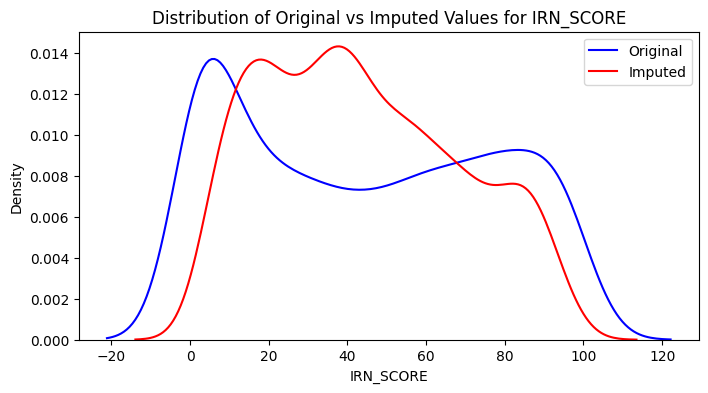

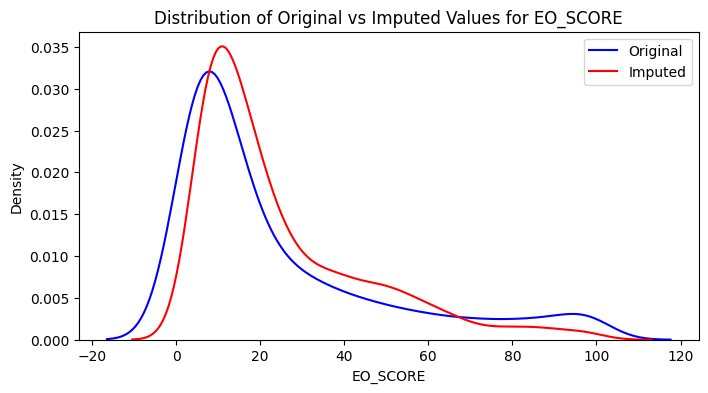

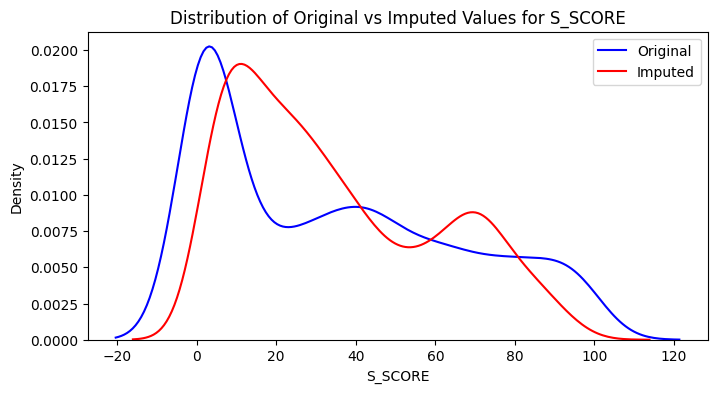

      target       R^2       RMSE        MAE
0  IRN_SCORE  0.677094  18.440290  14.704060
1   EO_SCORE  0.673742  14.753890  10.137168
2    S_SCORE  0.744509  15.812686  12.453490


In [11]:
synthetic_data = train_data.copy()
synthetic_data = synthetic_data.dropna()

for target in targets:
    mask = synthetic_data[target].notna()
    n_to_remove = int(0.4 * mask.sum())
    indices_to_nan = np.random.choice(synthetic_data[mask].index, n_to_remove, replace=False)
    synthetic_data.loc[indices_to_nan, target] = np.nan

# Dictionary to store evaluation metrics
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

# Impute each target column and calculate metrics
for target in targets:
    train_synthetic = synthetic_data[synthetic_data[target].notna()]
    test_synthetic = synthetic_data[synthetic_data[target].isna()]
    
    X_train = train_synthetic[features]
    y_train = train_synthetic[target]
    X_test = test_synthetic[features]
    y_true = train_data.loc[test_synthetic.index, target]
    
    # Retrieve best parameters for this target
    best_params = best_params_dict[target]
    
    # Set up RandomForestRegressor with best parameters
    rf = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=2025
    )
    
    # Fit and predict
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Calculate evaluation metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Append metrics for this target
    metrics['target'].append(target)
    metrics['R^2'].append(r2)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)
    
    # Plot distribution comparison
    plt.figure(figsize=(8, 4))
    sns.kdeplot(y_true, label='Original', color='blue')
    sns.kdeplot(y_pred, label='Imputed', color='red')
    plt.title(f"Distribution of Original vs Imputed Values for {target}")
    plt.xlabel(target)
    plt.legend()
    plt.show()

# Display metrics as a DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)